In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

tract_info = pd.read_csv('data/tract_info.csv')

df_subject = pd.read_csv('data/subject_info.csv')
df_areas = pd.read_csv('data/tract_cross-sectional-areas.csv')

cortices = list(set(tract_info.cortex))

df = df_areas.copy()
df['age'] = df_subject['age']

display(df)

,id,AF-L__Hipp-L_0,AF-L__Hipp-L_1,CG-L__CC__Hipp-L,CG-L__CC-isthmus__POS1-L_0,AF-L__Hipp-L_2,CC__Hipp-R,CG-L__CC__POS2-L,CC__CC-splenium__ProS-R,CG-L__CC__V3A-L,...,CG-L__CC__V2-L,AF-L__Hipp-L_5,IFO-R__PHA2-R_1,CC__V2-R,CC__CC-isthmus__CG-R__Hipp-R,AF-L__Hipp-R_4,IFO-R__ST-OCC-R__AF-L__Hipp-R,AF-L__FX-L__Hipp-L_1,CC__ILF-L__PHA3-L,age
0,HCD0001305,12.492314,45.948628,30.660106,0.637349,19.315874,4.014349,1.271122,1.694577,0.874725,...,0.596419,75.636652,7.823236,1.347300,0.315052,41.666059,6.953296,13.126395,1.840375,11.916667
1,HCD0008117,8.569758,16.414851,20.465766,1.045508,25.984212,3.048386,1.905560,1.562375,0.517304,...,0.745486,39.566787,5.701181,0.613398,1.199195,49.064373,2.756810,1.465629,2.315826,16.000000
2,HCD0021614,13.664400,20.100192,21.881002,0.914247,24.288038,2.593510,2.224498,1.477846,1.682928,...,0.936888,39.828287,8.416934,1.244614,1.100831,62.448173,4.250448,0.764498,17.686912,9.166667
3,HCD0022919,8.145933,38.417246,49.448629,0.972176,29.207022,3.494819,0.726577,1.947841,0.597824,...,0.893005,25.736385,16.929673,0.988442,0.322050,42.797630,10.479829,2.328043,1.489937,9.750000
4,HCD0026119,47.245156,49.228183,31.566864,0.984765,13.406142,2.268093,1.408846,1.103316,0.236176,...,0.817198,62.440291,7.925952,1.088180,0.000000,63.691935,9.128708,14.516532,0.143935,15.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,HCD2978386,5.760724,12.941554,17.122665,0.944236,12.814879,3.854952,0.631824,1.498024,1.165525,...,1.072270,40.501157,7.399635,0.992633,0.942437,22.557615,0.272407,0.388397,1.709457,9.166667
535,HCD2982579,19.673321,23.038178,28.887326,1.138459,20.916148,1.796392,1.766133,1.027417,0.415696,...,0.667545,43.755998,10.887571,0.642886,0.049749,51.279669,11.141329,8.097025,0.466146,18.750000
536,HCD2987185,7.963692,28.980848,38.550812,1.627673,18.021602,3.807203,2.101928,1.793933,1.358675,...,1.139409,51.958825,14.275613,1.624296,0.647867,39.495069,5.517050,2.153107,3.150470,14.583333
537,HCD2990073,20.310970,36.525024,26.188280,1.494767,18.840424,5.715446,1.209990,2.415746,0.639721,...,0.868245,62.043465,8.720110,2.129984,1.202670,30.424541,8.439853,2.999365,1.450308,13.583333


In [32]:
from pygam import GAM, s


def fit_gam(x: np.array, y: np.array, lam=1e3, n_values=500):

    g = GAM(s(0), lam=lam).fit(x, y)

    x_grid = np.linspace(x.min(), x.max(), n_values)
    y_grid = g.predict(x_grid)

    ci = g.confidence_intervals(x_grid, width=0.95)

    return x_grid, y_grid, ci


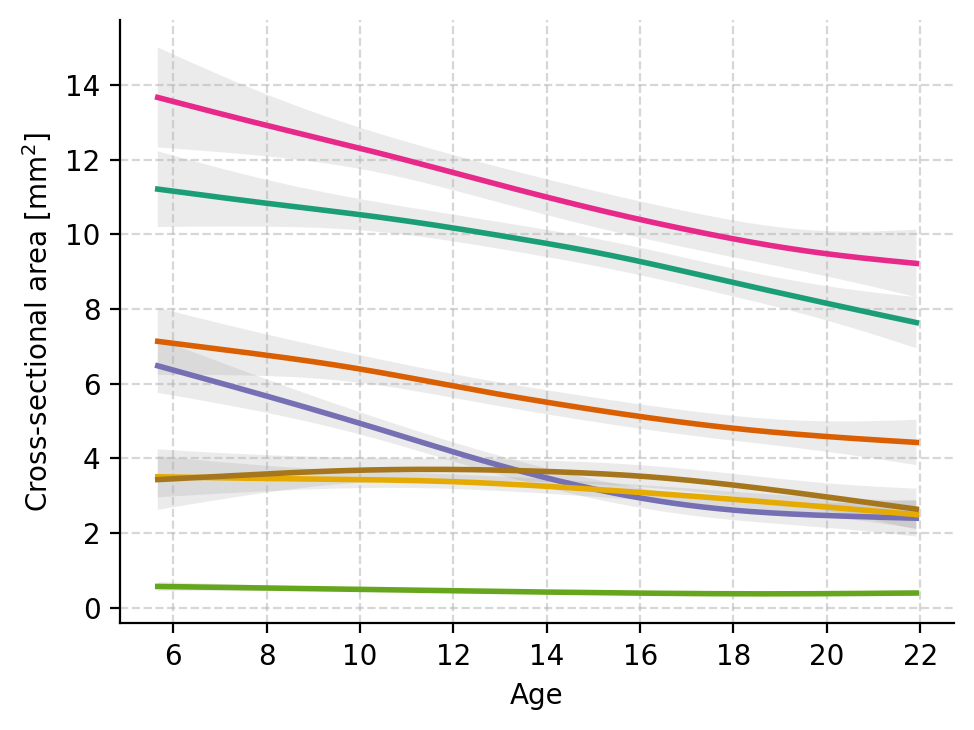

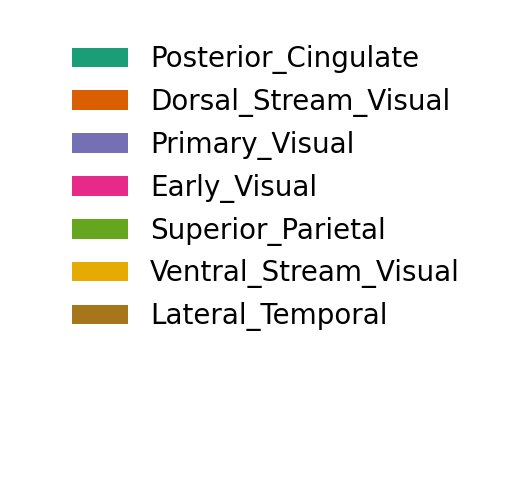

In [49]:


tract_colors = dict(zip(cortices, plt.get_cmap('Dark2').colors))

age = df['age'].values
cortices = tract_info[~np.isin(tract_info.cortex, ['Medial_Temporal'])].cortex.unique()


fig, ax = plt.subplots(figsize=(5, 3.75))


for idx, cortex in enumerate(cortices):

    tracts = tract_info[tract_info.cortex == cortex]['label']
    tract_area = df[tracts].sum(axis=1)

    x_grid, y_grid, ci = fit_gam(age, tract_area)

    ax.plot(
        x_grid, y_grid,
        lw=2,label=cortex, color=tract_colors[cortex]
    )
    ax.fill_between(
        x_grid, ci[:,0], ci[:,1],
        facecolor='tab:gray', alpha=0.15
    )


ax.set_xlabel('Age')
ax.set_ylabel('Cross-sectional area [mm$^2$]')
ax.grid(linestyle='--', alpha=.5)
sns.despine()

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3,3))

for cortex in cortices:
    ax.bar(0,0, color=tract_colors[cortex], label=cortex)

ax.legend(frameon=False)
ax.axis('off')
plt.show()

In [52]:
for cortex in cortices:
    tracts = tract_info[tract_info.cortex == cortex]['label']
    print(f'{cortex}:')
    display(pg.linear_regression(X=df['age'], y=df[tracts].sum(axis=1)))


Posterior_Cingulate:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,12.889534,0.497627,25.902006,1.365297e-96,0.086505,0.084803,11.912000,13.867067
1,age,-0.232751,0.032639,-7.131047,3.234247e-12,0.086505,0.084803,-0.296867,-0.168635


Dorsal_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,8.086894,0.441777,18.305362,1.588733e-58,0.065552,0.063812,7.219070,8.954717
1,age,-0.177844,0.028976,-6.137640,1.628324e-09,0.065552,0.063812,-0.234764,-0.120924


Primary_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,7.259425,0.359755,20.178792,8.198945e-68,0.171827,0.170285,6.552725,7.966125
1,age,-0.249066,0.023596,-10.555338,8.529554e-24,0.171827,0.170285,-0.295418,-0.202714


Early_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,15.021164,0.656886,22.867244,2.527128e-81,0.072759,0.071033,13.730784,16.311545
1,age,-0.279679,0.043085,-6.491361,1.937490e-10,0.072759,0.071033,-0.364315,-0.195044


Superior_Parietal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.590611,0.058111,10.163570,2.589785e-22,0.016003,0.014171,0.476459,0.704762
1,age,-0.011264,0.003811,-2.955237,3.261446e-03,0.016003,0.014171,-0.018751,-0.003777


Ventral_Stream_Visual:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.162976,0.270963,15.363607,2.033998e-44,0.028813,0.027005,3.630697,4.695254
1,age,-0.070938,0.017772,-3.991458,7.479917e-05,0.028813,0.027005,-0.105850,-0.036026


Lateral_Temporal:


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,4.397565,0.398330,11.040004,1.116869e-25,0.011691,0.009851,3.615089,5.180041
1,age,-0.065849,0.026126,-2.520394,1.201107e-02,0.011691,0.009851,-0.117171,-0.014526
